## **Proyecto final: Usando computación evolutiva para encontrar localizaciones optimas de una cadena de supermercados**

**Importando las librerias necesarias**

In [1]:
import pandas as pd
import math
import sys
import time
import numpy as np
from random import shuffle, random, sample, randint, randrange, uniform
from copy import deepcopy
import matplotlib.pyplot as plt

**Leyendo la informacion proporcionada**

In [2]:
dataset=pd.read_excel('UbicacionSupermercados/Candidatos_supermercados.xlsx')
dataset.head()

,ID,Descripcion,Latitud,Longitud,Poblacion500m
0,Punto 1,Esq. Benavides con Nicolas Dueñas,-12.04861,-77.06496,16500
1,Ponto 2,Sta Bernardita con Republica de Venezuela,-12.05956,-77.07583,18000
2,Ponto 3,Santa Susana con Santa Gertrudis,-12.06524,-77.07334,17000
3,Ponto 4,Belizario Sosa Pelaez,-12.05998,-77.06300,15000
4,Ponto 5,Esq. Aurelio Garcia y Miranono Arredondo,-12.05541,-77.07497,17100


In [3]:
lista_total_distancias={}
radio_tierra=6378 #radio ecuatorial
def getDistances(dataset):
    valores=dataset[['Latitud','Longitud']].values
    for i in range(len(valores)):
        for j in range(i+1,len(valores)):
            dif_lat=valores[j][0] - valores[i][0] #Hallamos la diferencia de latitud
            dif_lon=valores[j][1] - valores[i][1] #Hallamos la diferencia de longitud
            a=pow(math.sin(dif_lat/2),2)+(math.cos(valores[i][0])*(math.cos(valores[j][0])))*pow(math.sin(dif_lon/2),2)
            c=2*math.asin(min(1,math.sqrt(a)))
            lista_total_distancias[(i,j)]=radio_tierra * c 

In [4]:
getDistances(dataset)

In [5]:
lista_total_distancias

{(0, 1): 92.35295446475958,
 (0, 2): 115.8755225342369,
 (0, 3): 73.33205642013037,
 (0, 4): 70.50118889828475,
 (0, 5): 64.74963803997251,
 (0, 6): 57.25861687308397,
 (0, 7): 56.92094244740302,
 (0, 8): 42.95860192566178,
 (0, 9): 74.25837683934925,
 (0, 10): 80.63339298671539,
 (0, 11): 46.096392722693516,
 (0, 12): 75.69288747213537,
 (0, 13): 66.0958417722564,
 (0, 14): 175.77798424871992,
 (0, 15): 34.96779982995099,
 (0, 16): 44.07177671352194,
 (0, 17): 49.203089238753606,
 (0, 18): 154.40564557377718,
 (0, 19): 163.23579616635132,
 (0, 20): 122.82891473776172,
 (0, 21): 135.12158392803445,
 (0, 22): 179.47676279705934,
 (0, 23): 197.91709878422833,
 (0, 24): 271.2227939903601,
 (0, 25): 289.01290280404186,
 (0, 26): 306.59219932830814,
 (0, 27): 975.5508200505459,
 (0, 28): 965.8092067463914,
 (0, 29): 837.7828472947405,
 (0, 30): 827.188750506628,
 (0, 31): 808.8098633894306,
 (0, 32): 810.6145574766199,
 (0, 33): 791.2305179963006,
 (0, 34): 795.6649531770904,
 (0, 35): 782.

**Obj:Escoger los supermercados de manera que se maximice la suma de la población
que vive a 500m alrededor de los supermercados y la suma de las distancias entre los
supermercados escogidos.**

In [6]:
class Market(object):
    def __init__(self,ID,descr,pob,latitud,longitud):
        self.id=ID
        self.descr=descr
        self.pob=pob
        self.lat=latitud
        self.lon=longitud

In [7]:

class Individual:
    """ Implementa el individuo del AG. Un individuo tiene un cromosoma que es una lista de num_markets elementos (genes),
       cada gen i puede asumir dos posibles alelos: 0 o 1 (no incluir/incluir en la mochila el item i del pool) """

    def __init__(self, chromosome,maxMark=10):  # el constructor recibe un cromosoma
        self.chromosome = chromosome[:]  
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado
        self.maxMark=maxMark

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:],self.maxMark)
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:],self.maxMark)
        ind1,ind2=self.__verify([ind1,ind2])
        return [ind1, ind2]   
    
    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        for i in range(len(self.chromosome)):
            if uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1,self.maxMark)
        ind2 = Individual(chromosome2,self.maxMark)
        ind1,ind2=self.__verify([ind1,ind2])
        return [ind1, ind2] 
    
    #Es necesario aplicar mutacion ? Porque la funcion __verify tambien introduce exploracion al cambiar los bits aleatoriamente
    def mutation_flip(self):
        "Cambia aleatoriamente el alelo de un gen."
        new_chromosome = deepcopy(self.chromosome)
        mutGene = randrange(0,len(new_chromosome))   # escoge un gen para mutar
        if new_chromosome[mutGene] == 0:
            #Cambiaremos un cero a un uno, por lo que habrá un uno mas, por lo que se deberá cambiar otro uno a cero
            index_unos=[i for i in range(len(new_chromosome)) if new_chromosome[i] == 1]
            index_uno=sample(index_unos,1) #Obtenemos un index de todos los unos para cambiarlo a cero
            new_chromosome[mutGene] = 1 #Cambiamos a uno un cero
            new_chromosome[index_uno[0]]=0 #Cambiamos a cero un uno
        else:
            index_ceros=[i for i in range(len(new_chromosome)) if new_chromosome[i] == 0]
            index_cero=sample(index_ceros,1) #Obtenemos un index de todos los unos para cambiarlo a cero
            new_chromosome[mutGene] = 0 #Compensamos
            new_chromosome[index_cero[0]]=1 #Cambiamos a uno un cero
            
        return Individual(new_chromosome,self.maxMark)
        
    
    def __verify(self,individuos):
        """Funcion para forzar que existan 10 unos dentro del cromosoma
        """
        resultado=[]
        for ind in individuos:
            #resta_unos=longitud - 10 if longitud > 10 else 10 - longitud
            cant_unos=ind.chromosome.count(1)
            index_unos=[i for i in range(len(ind.chromosome)) if ind.chromosome[i] == 1] #Obtenemos los index de los unos dentro del cromosoma
            if cant_unos >self.maxMark: #Verificando si el individuo tiene mas de 10 unos
                #index_unos=[i for i in range(len(ind.chromosome)) if ind.chromosome[i] == 1] #Obtenemos los index de los unos dentro del cromosoma
                index_unos2chg=sample(index_unos,cant_unos - self.maxMark)# Obtenemos los index que cambiaremos a cero porque se pasó de 10
                for index in index_unos2chg:
                    ind.chromosome[index]=0
            elif cant_unos < self.maxMark: #Si el individuo tiene menos de 10 unos 
                #index_unos=[i for i in range(len(ind.chromosome)) if ind.chromosome[i] == 1]
                index_unos2chg=set(range(len(ind.chromosome))) - set(index_unos) #Quitamos los index en los cuales se encuentran los unos
                random_index=sample(index_unos2chg,self.maxMark - cant_unos) #Generamos index aletorios para completar a 10
                for index in random_index:
                    ind.chromosome[index]=1
            resultado.append(ind)
        return resultado


**Prueba del crossover_onepoint**

In [8]:
individuo1=Individual([1,1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1])
individuo2=Individual([1,1,1,1,1,0,1,1,0,0,1,1,1,1,1,0,0,0,0])

In [9]:
hijo1,hijo2=individuo1.crossover_onepoint(individuo2)

In [10]:
hijo1.chromosome

[1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0]

In [11]:
hijo2.chromosome

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1]

**Prueba de la mutacion**

In [12]:
hijo_mutado=hijo1.mutation_flip()
hijo_mutado.chromosome

[1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0]

In [13]:
hijo_mutado2=hijo2.mutation_flip()
hijo_mutado2.chromosome

[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1]

In [14]:
def get_fitness_lista(chromosome, markets):
    """Retorna el fitness del cromosoma pasado. Fitness es el valor total de los markets incluidos en el cromosoma
        """
    fitness=0
    markets_elegidos=[]
    sum_pob=0
    sum_dist=0
    for i in range(len(markets)):
        if chromosome[i] == 1:  # si el market i esta incluido en el cromosoma, acumula su poblacion y distancia
            sum_pob += markets[i].pob
            markets_elegidos.append(i)
            
    for j in markets_elegidos:
        for k in markets_elegidos[j+1:]:
            #sum_dist+=lista_total_distancias[(markets_elegidos[j],markets_elegidos[k])]
            sum_dist=sum_dist+lista_total_distancias[(j,k)]
    
    return sum_pob + sum_dist

In [15]:
def get_fitness(chromosome, markets):
    """Retorna el fitness del cromosoma pasado. Fitness es el valor total de los markets incluidos en el cromosoma
        """
    fitness = 0 # initialize fitness to 0
    lista_distancias=[]
    sum_pob=0
    sum_dist=0
    for i in range(len(markets)):
        if chromosome[i] == 1:  # si el market i esta incluido en el cromosoma, acumula su poblacion y distancia
            sum_pob += markets[i].pob
            lista_distancias.append((markets[i].lat,markets[i].lon))
            
    radio_tierra=6378 #radio ecuatorial
    for i in range(len(lista_distancias)):
        for j in lista_distancias[i+1:]:
            dif_lat=j[0] - lista_distancias[i][0] #Hallamos la diferencia de latitud
            dif_lon=j[1] - lista_distancias[i][1] #Hallamos la diferencia de longitud
            a=pow(math.sin(dif_lat/2),2)+(math.cos(lista_distancias[i][0])*(math.cos(j[0])))*pow(math.sin(dif_lon/2),2)
            c=2*math.asin(min(1,math.sqrt(a)))
            sum_dist+=radio_tierra * c 
    fitness=sum_pob + sum_dist
    
    return fitness

In [16]:
def evaluate_population(population, markets):
    """ Evalua una poblacion de individuos con la funcion get_fitness """
    pop_size = len(population)
    for i in range(pop_size):
        if population[i].fitness == -1:    # evalua solo si el individuo no esta evaluado
            #population[i].fitness = get_fitness(population[i].chromosome, markets)
            population[i].fitness = get_fitness_lista(population[i].chromosome, markets)

In [17]:
def init_population(pop_size, chromosome_size=60,maxMark=10):
    """Inicializa una poblacion de pop_size individuos, cada cromosoma de individuo de tamaño chromosome_size.
       """
    population = []
    for i in range(pop_size):
        index_unos=sample(range(chromosome_size),maxMark)
        new_chromosome=[0 if i not in index_unos else 1 for i in range(chromosome_size)]
        population.append( Individual(new_chromosome,maxMark))
    return population

In [18]:
def select_parents_roulette(population):
    pop_size = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(pop_size):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
    
    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(pop_size):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

In [19]:
def sus(poblacion,num_padres):
    poblacion_local=poblacion[:]
    padres=[]
    fitness_total=sum([chromosome.fitness for chromosome in poblacion_local])
    agujas=np.linspace(0,fitness_total,num_padres+1)
    r_aleatorios=[int(uniform(agujas[i],agujas[i+1])) for i in range(len(agujas)-1)]
    for r in r_aleatorios:
        fitness_acumulado=0
        for chromosome in poblacion_local:
            fitness_acumulado+=chromosome.fitness
            if fitness_acumulado >= r:
                padres.append(chromosome)
                break
                
    return padres

In [20]:
def select_survivors(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors):
        next_population.append(population[isurvivors[i]])
    return next_population

In [21]:
def genetic_algorithm(population, markets, ngen=100, pmut=0.1, crossover="onepoint", mutation="flip",select='roulette'):
    
    pop_size = len(population)
    evaluate_population(population, markets)  # evalua la poblacion inicial
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]  # mejor individuo
    bestfitness = [population[ibest[0]].fitness]  # fitness del mejor individuo
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))
    
    for g in range(ngen):   # Por cada generacion

        ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
        mating_pool = []
        if select == 'roulette':
            for i in range(int(pop_size/2)): mating_pool.append(select_parents_roulette(population)) 
        elif select == 'sus':
            for i in range(int(pop_size/2)): mating_pool.append(sus(population,2)) 
        
        ## Crea la poblacion descendencia cruzando las parejas del mating pool 
        offspring_population = []
        for i in range(len(mating_pool)): 
            if crossover == "onepoint":
                offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
            elif crossover == "uniform":
                offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme
            else:
                raise NotImplementedError

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if uniform(0, 1) < pmut: 
                if mutation == "flip":
                    offspring_population[i] = offspring_population[i].mutation_flip() # cambia el alelo de un gen
                else:
                    raise NotImplementedError   
        
        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, markets)   # evalua la poblacion descendencia
        
        ## Selecciona pop_size individuos para la sgte. generación de la union de la pob. actual y  pob. descendencia
        population = select_survivors(population, offspring_population, pop_size)

        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        bestfitness.append(population[ibest[0]].fitness)
        
        if (g % 10 == 0):  # muestra resultados cada 10 generaciones
            print("generacion {}, Mejor fitness = {})".format(g, population[ibest[0]].fitness))
        
    print("Mejor individuo en la ultima generacion = {} (fitness = {})".format(population[ibest[0]].chromosome, population[ibest[0]].fitness))
    return population[ibest[0]], bestfitness  # devuelve el mejor individuo y la lista de mejores fitness x gen

In [23]:
marketPool=[]
for i in range(len(dataset)):
    ID=dataset.iloc[i].ID
    descp=dataset.iloc[i].Descripcion
    lat=dataset.iloc[i].Latitud
    lon=dataset.iloc[i].Longitud
    pob=dataset.iloc[i].Poblacion500m
    marketPool.append(Market(ID,descp,pob,lat,lon))

In [24]:
marketPool[0].pob

16500

Poblacion inicial, best_fitness = 172491.8900195059
generacion 0, Mejor fitness = 173279.8504391124)
generacion 10, Mejor fitness = 189758.94005597016)
generacion 20, Mejor fitness = 192835.88587000384)
generacion 30, Mejor fitness = 192835.88587000384)
generacion 40, Mejor fitness = 192835.88587000384)
generacion 50, Mejor fitness = 192835.88587000384)
generacion 60, Mejor fitness = 193353.41645631232)
generacion 70, Mejor fitness = 193353.41645631232)
generacion 80, Mejor fitness = 193353.41645631232)
generacion 90, Mejor fitness = 193353.41645631232)
generacion 100, Mejor fitness = 193353.41645631232)
generacion 110, Mejor fitness = 193409.90950866626)
generacion 120, Mejor fitness = 193409.90950866626)
generacion 130, Mejor fitness = 193409.90950866626)
generacion 140, Mejor fitness = 193409.90950866626)
generacion 150, Mejor fitness = 193409.90950866626)
generacion 160, Mejor fitness = 193409.90950866626)
generacion 170, Mejor fitness = 193409.90950866626)
generacion 180, Mejor fi

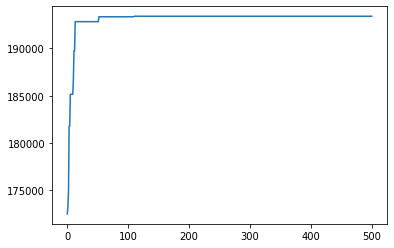

In [25]:
## Hiperparametros del algoritmo genetico
POP_SIZE = 50       # numero de individuos
GENERATIONS = 500   # numero de generaciones
PMUT = 1        # taza de mutacion
#NUM_MARKETS=60
## Inicializa una poblacion inicial de forma aleatoria
population = init_population(POP_SIZE,maxMark=10)

# Evolue la poblacion con el algoritmo genetico (cruzamiento 'onepoint', )
best_ind, bestfitness = genetic_algorithm(population, marketPool, GENERATIONS, PMUT, crossover="uniform", mutation="flip",select='roulette')

# muestra la evolucion del mejor fitness
plt.plot(bestfitness)
plt.show()
#198713.940505528 convergencia generacion=30
#prueba  193409.90950866626

In [26]:
[(marketPool[i].id,marketPool[i].descr,marketPool[i].pob) for i in range(len(best_ind.chromosome)) if best_ind.chromosome[i]==1]

[('Punto 1', 'Esq. Benavides con Nicolas Dueñas', 16500),
 ('Ponto 2', 'Sta Bernardita con Republica de Venezuela', 18000),
 ('Ponto 3', 'Santa Susana con Santa Gertrudis', 17000),
 ('Punto 49', 'Av. la Paz 838, Miraflores 15086', 18400),
 ('Punto 50', 'Calle San Martin 537, Miraflores 15074', 18800),
 ('Punto 51', 'Av 28 de Julio 331, Miraflores 15074', 18300),
 ('Punto 56', 'Calle Berlin 468, Miraflores 15074', 19000),
 ('Punto 57', 'Calle San Martin 300, Miraflores 15074', 18600),
 ('Punto 59', 'Calle de las Pizzas 104, Miraflores 15074', 18500),
 ('Punto 60', 'Calle Enrique Palacios 140, Miraflores 15074\xa0', 20000)]

## **NSGA-II**

In [36]:
def get_fitness_nsga(chromosome, markets):
    fitnesses=np.zeros(2) #cantidad de objetivos a medir
    markets_elegidos=[]
    sum_pob=0
    sum_dist=0
    for i in range(len(markets)):
        if chromosome[i] == 1:  # si el market i esta incluido en el cromosoma, acumula su poblacion y distancia
            sum_pob += markets[i].pob
            markets_elegidos.append(i)
            
    for j in markets_elegidos:
        for k in markets_elegidos[j+1:]:
            #sum_dist+=lista_total_distancias[(markets_elegidos[j],markets_elegidos[k])]
            sum_dist=sum_dist+lista_total_distancias[(j,k)]
    fitnesses[0]=sum_pob
    fitnesses[1]=sum_dist
    return fitnesses

In [34]:
def evaluate_population_nsga(population, markets):
    """ Evalua una poblacion de individuos con la funcion get_fitness """
    pop_size = len(population)
    for i in range(pop_size):
        if population[i].fitness == -1:    # evalua solo si el individuo no esta evaluado
            #population[i].fitness = get_fitness(population[i].chromosome, markets)
            population[i].fitness = get_fitness_nsga(population[i].chromosome, markets)

In [28]:
def build_offspring_population(population, crossover, mutation, pmut):     
    """ Construye una poblacion hija con los operadores de cruzamiento y mutacion pasados
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        pmut:       taza de mutacion
    """
    pop_size = len(population)
    
    ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
    mating_pool = []
    for i in range(int(pop_size/2)): 
        # escoge dos individuos diferentes aleatoriamente de la poblacion
        permut = np.random.permutation( pop_size )
        mating_pool.append( (population[permut[0]], population[permut[1]] ) ) 
        
    ## Crea la poblacion descendencia cruzando las parejas del mating pool 
    offspring_population = []
    for i in range(len(mating_pool)): 
        if crossover == "onepoint":
            offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
        elif crossover == "uniform":
            offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme
        else:
            raise NotImplementedError

    ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
    for i in range(len(offspring_population)):
        if uniform(0, 1) < pmut: 
            if mutation == "flip":
                offspring_population[i] = offspring_population[i].mutation_flip() # cambia el alelo de un gen
            else:
                raise NotImplementedError   
                
    return offspring_population


In [29]:
def get_crowding_distances(fitnesses):
    """
    La distancia crowding de un individuo es la diferencia del fitness mas proximo hacia arriba menos el fitness mas proximo 
    hacia abajo. El valor crowding total es la suma de todas las distancias crowdings para todos los fitness
    """
    #fitnesses de la forma np.array( [ [23,23],[12,21],[2,2] ])
    pop_size = len(fitnesses[:, 0])
    num_objectives = len(fitnesses[0, :])

    # crea matriz crowding. Filas representan individuos, columnas representan objectives
    crowding_matrix = np.zeros((pop_size, num_objectives))

    # normaliza los fitnesses entre 0 y 1 (ptp es max - min)
    # Es importante normalizar los fitness porque pueden venir con diferentes unidades de medida
    normalized_fitnesses = (fitnesses - fitnesses.min(0)) / fitnesses.ptp(0)

    for col in range(num_objectives):   # Por cada objective
        crowding = np.zeros(pop_size)

        # puntos extremos tienen maximo crowding
        crowding[0] = 1
        crowding[pop_size - 1] = 1

        # ordena los fitness normalizados del objectivo actual
        sorted_fitnesses = np.sort(normalized_fitnesses[:, col])
        sorted_fitnesses_index = np.argsort(normalized_fitnesses[:, col])

        # Calcula la distancia crowding de cada individuo como la diferencia de score de los vecinos
        crowding[1:pop_size - 1] = (sorted_fitnesses[2:pop_size] - sorted_fitnesses[0:pop_size - 2])

        # obtiene el ordenamiento original
        re_sort_order = np.argsort(sorted_fitnesses_index)
        sorted_crowding = crowding[re_sort_order]

        # Salva las distancias crowdingpara el objetivo que se esta iterando
        crowding_matrix[:, col] = sorted_crowding

    # Obtiene las distancias crowding finales sumando las distancias crowding de cada objetivo 
    crowding_distances = np.sum(crowding_matrix, axis=1)

    return crowding_distances

In [30]:
def select_by_crowding(population, num_individuals):
    """
    Selecciona una poblacion de individuos basado en torneos de pares de individuos: dos individuos se escoge al azar
    y se selecciona el mejor segun la distancia crowding. Se repite hasta obtener num_individuals individuos
    """    
    population = deepcopy(population)
    pop_size = len(population)
    num_objectives = len(population[0].fitness)
    
    # extrae los fitness de la poblacion en la matriz fitnesses
    fitnesses = np.zeros([pop_size, num_objectives])
    for i in range(pop_size): fitnesses[i,:] = population[i].fitness
        
    # obtiene las  distancias  crowding
    crowding_distances = get_crowding_distances(fitnesses)   
    
    population_selected = []   # poblacion escogida

    for i in range(num_individuals):  # por cada individuo a seleccionar

        # escoje dos individuos aleatoriamente de la poblacion no escogida aun
        permut = np.random.permutation( len(population) )
        ind1_id = permut[0]
        ind2_id = permut[1]

        # Si ind1_id es el mejor
        if crowding_distances[ind1_id] >= crowding_distances[ind2_id]:

            # traslada el individuo ind1 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind1_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind1_id, axis=0)
            
        else:  # Si ind2_id es el mejor
            
            # traslada el individuo ind2 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind2_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind2_id, axis=0)

    return (population_selected)

In [31]:
def get_paretofront_population(population):
    """
    Obtiene de population la poblacion de individups de la frontera de Pareto, 
    """
    population = deepcopy(population)
    pop_size = len(population)
    
    # todos los individuos son inicialmente asumidos como la frontera de Pareto
    pareto_front = np.ones(pop_size, dtype=bool)
    
    for i in range(pop_size): # Compara cada individuo contra todos los demas
        for j in range(pop_size):
            # Chequea si individuo 'i' es dominado por individuo 'j'
            if all(population[j].fitness >= population[i].fitness) and any(population[j].fitness > population[i].fitness): #NO es OR ?
                # j domina i -> señaliza que individuo 'i' como no siendo parte de la frontera de Pareto
                pareto_front[i] = 0
                break   # Para la busqueda para 'i' (no es necesario hacer mas comparaciones)

    paretofront_population = []
    for i in range(pop_size):  # construye la lista de individuos de la frontera de Pareto 
        if pareto_front[i] == 1: paretofront_population.append(population[i])
        
    return paretofront_population

In [32]:
def build_next_population(population, min_pop_size, max_pop_size):
    """
    Construye la poblacion de la siguiente generacion añadiendo sucesivas fronteras de Pareto hasta 
    tener una poblacion de al menos min_pop_size individuos. Reduce la frontera de Pareto con el metodo de
    crowding distance si al agregar la frontera excede el tamaño maximo de la poblacion (max_pop_size)
    """
    population = deepcopy(population)
    pareto_front = []
    next_population = []
    
    while len(next_population) < min_pop_size:   # mientras la poblacion no tenga el tamaño minimo
        # obtiene la poblacion frontera de Pareto actual
        paretofront_population = get_paretofront_population(population)
        
        # si poblacion actual + paretofront excede el maximo permitido -> reduce paretofront con el metodo de crowding
        combined_population_size = len(next_population) + len(paretofront_population)
        if  combined_population_size > max_pop_size:
            paretofront_population = select_by_crowding( paretofront_population, max_pop_size-len(next_population) ) 
        
        # Adiciona la frontera de Pareto (original o reducida) a la poblacion en construccion
        next_population.extend( paretofront_population )
    
        # remueve de population los individuos que fueron agregados a next_population 
        for i in range( len(paretofront_population) ):
            for j in range( len(population) ):
                if all( np.asarray(paretofront_population[i].chromosome) == np.asarray(population[j].chromosome) ):
                    del(population[j])
                    break
                    
    return next_population

In [37]:
## Hiperparametros del algoritmo genetico
POP_SIZE = 50       # numero de individuos
GENERATIONS = 500   # numero de generaciones
PMUT = 1        # taza de mutacion
MIN_POP_SIZE = 100    # numero de individuos minimo
MAX_POP_SIZE = 100    # numero de individuos maximo
#NUM_MARKETS=60
## Inicializa una poblacion inicial de forma aleatoria
P = init_population(POP_SIZE,maxMark=10)

evaluate_population_nsga(P,marketPool)    #  evalua la poblacion inicial
## Ejecuta los ciclos evolutivos 
for g in range(GENERATIONS):   # Por cada generacion
    
    if g %10 == 0:
        print ('Generacion {} (de {}) '.format(g, GENERATIONS))
    
    ## genera y evalua la poblacion hija    
    Q = build_offspring_population(P, "uniform", "flip", PMUT)
    evaluate_population_nsga(Q, marketPool)
    
    ## une la poblacion padre y la poblacion hija
    P.extend(Q) 
    
    ## Construye la poblacion de la siguiente generacion
    P = build_next_population(P, MIN_POP_SIZE, MAX_POP_SIZE)

# Obtiene la poblacion de la frontera de pareto final 
pareto_front_population = get_paretofront_population(P)

Generacion 0 (de 500) 
Generacion 10 (de 500) 
Generacion 20 (de 500) 
Generacion 30 (de 500) 
Generacion 40 (de 500) 
Generacion 50 (de 500) 
Generacion 60 (de 500) 
Generacion 70 (de 500) 
Generacion 80 (de 500) 
Generacion 90 (de 500) 
Generacion 100 (de 500) 
Generacion 110 (de 500) 
Generacion 120 (de 500) 
Generacion 130 (de 500) 
Generacion 140 (de 500) 
Generacion 150 (de 500) 
Generacion 160 (de 500) 
Generacion 170 (de 500) 
Generacion 180 (de 500) 
Generacion 190 (de 500) 
Generacion 200 (de 500) 
Generacion 210 (de 500) 
Generacion 220 (de 500) 
Generacion 230 (de 500) 
Generacion 240 (de 500) 
Generacion 250 (de 500) 
Generacion 260 (de 500) 
Generacion 270 (de 500) 
Generacion 280 (de 500) 
Generacion 290 (de 500) 
Generacion 300 (de 500) 
Generacion 310 (de 500) 
Generacion 320 (de 500) 
Generacion 330 (de 500) 
Generacion 340 (de 500) 
Generacion 350 (de 500) 
Generacion 360 (de 500) 
Generacion 370 (de 500) 
Generacion 380 (de 500) 
Generacion 390 (de 500) 
Generacion 

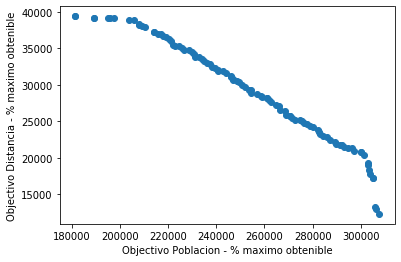

In [41]:
## Plotea los individuos de la frontera de Pareto final
CHROMOSOME_SIZE = 60 
pop_size = len(pareto_front_population)
num_objectives = len(pareto_front_population[0].fitness)
    
# extrae los fitness de la poblacion en la matriz fitnesses
fitnesses = np.zeros([pop_size, num_objectives])
for i in range(pop_size): fitnesses[i,:] = pareto_front_population[i].fitness

x = fitnesses[:, 0]/CHROMOSOME_SIZE*100
y = fitnesses[:, 1]/CHROMOSOME_SIZE*100
plt.xlabel('Objectivo Poblacion - % maximo obtenible') #Primer objetivo: Maximizar el valor de la mochila
plt.ylabel('Objectivo Distancia - % maximo obtenible') #Segundo objetivo: Minimizar el peso de la mochila
plt.scatter(x,y)
#plt.savefig('pareto.png')
plt.show()


In [60]:
#Verificacion si la solucion que nos otorgó el monoobjetivo es parte de las soluciones obtenidas por NSGA-II
cromosomas=[indi.chromosome for indi in pareto_front_population]
valor=True if best_ind.chromosome in cromosomas else False
valor

True